In [28]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
import transformers, datasets, torch, os, glob
import warnings
warnings.filterwarnings("ignore", message="IProgress not found.*")
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("torch:", torch.__version__)
print("cuda:", torch.cuda.is_available())


transformers: 4.57.3
datasets: 4.4.1
torch: 2.9.1
cuda: False


In [29]:
TSV_PATH = "bert-humaid/events_set1_combined_clean.tsv"  

DEV_SPLIT_VALUE = "dev"   

TEXT_COLUMNS = ["tweet_text", "text_clean"]

MODEL_NAME = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 16
LR = 2e-5
EPOCHS = 2
WEIGHT_DECAY = 0.01
SEED = 42


In [30]:
def load_local_dataset(tsv_path, dev_split_value="dev"):
    raw_datasets = load_dataset("csv", data_files=tsv_path, sep="\t")
    full = raw_datasets["train"]

    train_ds = full.filter(lambda ex: ex["split"] == "train")
    val_ds   = full.filter(lambda ex: ex["split"] == dev_split_value)
    test_ds  = full.filter(lambda ex: ex["split"] == "test")

    dataset = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})
    print(dataset)
    return dataset

dataset = load_local_dataset(TSV_PATH, DEV_SPLIT_VALUE)


DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'tweet_text', 'class_label', 'place', 'Disaster', 'year', 'split', 'text_clean'],
        num_rows: 30381
    })
    validation: Dataset({
        features: ['tweet_id', 'tweet_text', 'class_label', 'place', 'Disaster', 'year', 'split', 'text_clean'],
        num_rows: 4422
    })
    test: Dataset({
        features: ['tweet_id', 'tweet_text', 'class_label', 'place', 'Disaster', 'year', 'split', 'text_clean'],
        num_rows: 8606
    })
})


In [31]:
def build_label_mappings(dataset):
    labels = sorted(set(dataset["train"]["class_label"]))
    label2id = {lbl: i for i, lbl in enumerate(labels)}
    id2label = {i: lbl for lbl, i in label2id.items()}
    print("num_labels:", len(labels))
    return labels, label2id, id2label

def add_numeric_labels(dataset, label2id):
    def encode_label(example):
        example["label"] = label2id[example["class_label"]]
        return example
    return dataset.map(encode_label)

labels, label2id, id2label = build_label_mappings(dataset)
dataset = add_numeric_labels(dataset, label2id)


num_labels: 10


In [32]:
def tokenize_dataset(dataset, tokenizer, text_column, max_length=128):
    def preprocess_function(examples):
        return tokenizer(
            examples[text_column],
            truncation=True,
            max_length=max_length,
        )

    cols_to_keep = [text_column, "label"]
    cols_to_remove = [c for c in dataset["train"].column_names if c not in cols_to_keep]

    encoded_dataset = dataset.map(
        preprocess_function,
        batched=True,
        remove_columns=cols_to_remove,
    )
    return encoded_dataset


In [33]:
def compute_metrics(eval_pred):
    logits, labels_ = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels_, preds)
    macro_f1 = f1_score(labels_, preds, average="macro")
    return {"accuracy": acc, "macro_f1": macro_f1}


In [34]:
def get_latest_checkpoint(output_dir):
    """
    Return latest checkpoint path like .../checkpoint-XXXX if exists, else None.
    """
    if not os.path.isdir(output_dir):
        return None
    ckpts = glob.glob(os.path.join(output_dir, "checkpoint-*"))
    if not ckpts:
        return None
    # sort by step number
    ckpts_sorted = sorted(ckpts, key=lambda p: int(p.split("-")[-1]))
    return ckpts_sorted[-1]


In [35]:
def train_and_evaluate_on_column(dataset, labels, label2id, id2label, text_column):
    print("\n==============================")
    print(f"Training on column: {text_column}")
    print("==============================")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    encoded_dataset = tokenize_dataset(dataset, tokenizer, text_column=text_column, max_length=MAX_LENGTH)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id,
    )

    output_dir = f"./bert-local-{text_column}"

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",     # transformers 4.57.3
        save_strategy="epoch",
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=WEIGHT_DECAY,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        seed=SEED,
        report_to="none",
    )

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    latest_ckpt = get_latest_checkpoint(output_dir)
    if latest_ckpt is not None:
        print("Resuming from checkpoint:", latest_ckpt)
        trainer.train(resume_from_checkpoint=latest_ckpt)
    else:
        print("No checkpoint found. Training from scratch.")
        trainer.train()

    test_metrics = trainer.evaluate(encoded_dataset["test"])
    print(f"Test metrics for {text_column}:", test_metrics)

    return test_metrics, output_dir


In [36]:
results = {}

for col in TEXT_COLUMNS:
    metrics, outdir = train_and_evaluate_on_column(dataset, labels, label2id, id2label, text_column=col)
    results[col] = {"metrics": metrics, "output_dir": outdir}

print("\n========== Summary ==========")
for col in TEXT_COLUMNS:
    print(col, ":", results[col]["metrics"])



Training on column: tweet_text


Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422/4422 [00:00<00:00, 31110.40 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/zh/4240p9tx61x1blz5b026stch0000gn/T/ipykernel_62076/2184567146.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Resuming from checkpoint: ./bert-local-tweet_text/checkpoint-3798


Epoch,Training Loss,Validation Loss


/Users/xingchen/PycharmProjects/PythonProject/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Test metrics for tweet_text: {'eval_loss': 0.5999653935432434, 'eval_accuracy': 0.7927027655124332, 'eval_macro_f1': 0.749832537128683, 'eval_runtime': 12.9563, 'eval_samples_per_second': 664.231, 'eval_steps_per_second': 41.524, 'epoch': 2.0}

Training on column: text_clean


Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422/4422 [00:00<00:00, 85274.93 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/zh/4240p9tx61x1blz5b026stch0000gn/T/ipykernel_62076/2184567146.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Resuming from checkpoint: ./bert-local-text_clean/checkpoint-3798


Epoch,Training Loss,Validation Loss


/Users/xingchen/PycharmProjects/PythonProject/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Test metrics for text_clean: {'eval_loss': 0.6045723557472229, 'eval_accuracy': 0.7899140134789682, 'eval_macro_f1': 0.7477449315835132, 'eval_runtime': 10.8846, 'eval_samples_per_second': 790.659, 'eval_steps_per_second': 49.428, 'epoch': 2.0}

========== Summary ==========
tweet_text : {'eval_loss': 0.5999653935432434, 'eval_accuracy': 0.7927027655124332, 'eval_macro_f1': 0.749832537128683, 'eval_runtime': 12.9563, 'eval_samples_per_second': 664.231, 'eval_steps_per_second': 41.524, 'epoch': 2.0}
text_clean : {'eval_loss': 0.6045723557472229, 'eval_accuracy': 0.7899140134789682, 'eval_macro_f1': 0.7477449315835132, 'eval_runtime': 10.8846, 'eval_samples_per_second': 790.659, 'eval_steps_per_second': 49.428, 'epoch': 2.0}


In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch, Rectangle
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def normalize_01(x):
    x = np.asarray(x, dtype=np.float64)
    mn, mx = x.min(), x.max()
    return (x - mn) / (mx - mn + 1e-12)

def get_attn_heads_and_tokens(model_dir, text, layer_idx, max_length=64):
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    model.eval()

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    layer_attn = outputs.attentions[layer_idx][0]  # [H, L, L]
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    return layer_attn.cpu().numpy(), tokens

def find_query_index(tokens, query):
    if query in tokens:
        return tokens.index(query)
    norm = [t.replace("##", "") for t in tokens]
    for i, t in enumerate(norm):
        if t == query:
            return i
    for i, t in enumerate(norm):
        if query in t:
            return i
    raise ValueError(f"Cannot find query token '{query}' in tokens: {tokens}")

def plot_multhead_paperstyle(tokens, layer_attn, query_idx, title, out_png, top_k=8,
                             x_left=0.08, x_right=0.50, x_grid=0.58, grid_w=0.18):
    """
    tokens: list length L
    layer_attn: [H, L, L]
    """
    H, L, _ = layer_attn.shape
    weights_h = layer_attn[:, query_idx, :]      # [H, L]
    weights_mean = weights_h.mean(axis=0)        # [L]

    order = np.argsort(-weights_mean)
    keep = set(range(L)) if top_k is None else set(order[:top_k].tolist())

    weights_h_01 = normalize_01(weights_h.reshape(-1)).reshape(H, L)
    w_mean_01 = normalize_01(weights_mean)

    fig = plt.figure(figsize=(8.6, 4.8))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()
    fig.suptitle(title, y=0.98, fontsize=12)

    y_top, y_bottom = 0.88, 0.12
    ys = np.linspace(y_top, y_bottom, L)

    cell_h = (y_top - y_bottom) / (L - 1) * 0.55
    cell_w = grid_w / H * 0.98  # tighter blocks
    cmap = plt.get_cmap("Blues")

    # Left tokens
    for i, (tok, y) in enumerate(zip(tokens, ys)):
        if i == query_idx:
            ax.text(x_left, y, tok, fontsize=11, va="center",
                    bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="none"))
        else:
            ax.text(x_left, y, tok, fontsize=11, va="center")

    # Right tokens
    for i, (tok, y) in enumerate(zip(tokens, ys)):
        ax.text(x_right, y, tok, fontsize=11, va="center")

    # Head grid (H blocks per token)
    for i, y in enumerate(ys):
        for h in range(H):
            x0 = x_grid + h * (grid_w / H)
            rect = Rectangle((x0, y - cell_h / 2), cell_w, cell_h,
                             facecolor=cmap(weights_h_01[h, i]), edgecolor="none")
            ax.add_patch(rect)

    # Lines: query -> right side (connect to grid edge for a cleaner look)
    qy = ys[query_idx]
    for i, y in enumerate(ys):
        if i not in keep:
            continue
        alpha = 0.08 + 0.92 * w_mean_01[i]
        lw = 0.3 + 2.8 * w_mean_01[i]
        con = ConnectionPatch(
            xyA=(x_left + 0.07, qy), coordsA=ax.transAxes,
            xyB=(x_grid - 0.01, y), coordsB=ax.transAxes,  # connect to grid
            color=(0, 0, 0, alpha), linewidth=lw
        )
        ax.add_artist(con)

    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

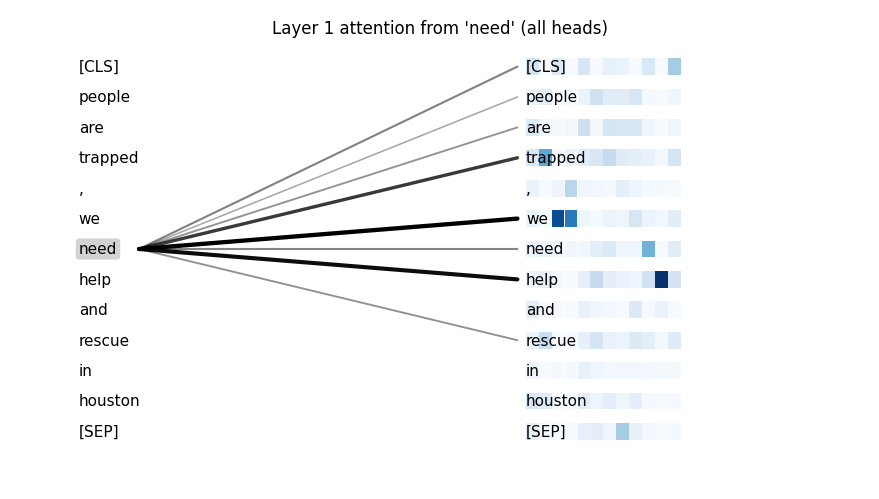

Saved: Fig3.png


In [24]:

# ====== set your inputs ======
MODEL_DIR = "./bert-local-tweet_text/checkpoint-3798"
TEXT = "people are trapped, we need help and rescue in houston"
QUERY_TOKEN_STR = "need"
LAYER_IDX = 0
MAX_LENGTH = 64
OUT_PNG = "Fig3.png"     # 建议直接输出 Fig3.png
TOP_K = 8
# ============================

layer_attn, tokens = get_attn_heads_and_tokens(MODEL_DIR, TEXT, LAYER_IDX, max_length=MAX_LENGTH)
qidx = find_query_index(tokens, QUERY_TOKEN_STR)
title = f"Layer {LAYER_IDX+1} attention from '{tokens[qidx]}' (all heads)"
plot_multhead_paperstyle(tokens, layer_attn, qidx, title, OUT_PNG, top_k=TOP_K,
                         x_left=0.080, x_right=0.60, x_grid=0.6, grid_w=0.18)

In [25]:
import random
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.manifold import TSNE

# ========= EDIT HERE =========
TSV_PATH = "bert-humaid/events_set1_combined_clean.tsv"   # your TSV
TEXT_COLUMN = "tweet_text"                               # "tweet_text" or "text_clean"
FINETUNED_MODEL_DIR = "./bert-local-tweet_text/checkpoint-3798"
DEV_SPLIT_VALUE = "dev"                                  # "dev" or "validation"

NUM_SAMPLES = 500
BERT_NAME = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 32
SEED = 42

OUT_PNG = "Fig4.png"
# =============================

# device (cuda/mps/cpu)
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print("Using device:", DEVICE)


Using device: mps


In [26]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def load_local_tsv_dataset(tsv_path, dev_split_value="dev"):
    raw = load_dataset("csv", data_files=tsv_path, sep="\t")["train"]
    train_ds = raw.filter(lambda ex: ex["split"] == "train")
    dev_ds   = raw.filter(lambda ex: ex["split"] == dev_split_value)
    test_ds  = raw.filter(lambda ex: ex["split"] == "test")
    ds = DatasetDict({"train": train_ds, "validation": dev_ds, "test": test_ds})
    print(ds)
    return ds


def build_label_mappings(dataset):
    labels = sorted(set(dataset["train"]["class_label"]))
    label2id = {lbl: i for i, lbl in enumerate(labels)}
    id2label = {i: lbl for lbl, i in label2id.items()}
    return labels, label2id, id2label


def add_numeric_labels(dataset, label2id):
    def encode_label(ex):
        ex["label"] = label2id[ex["class_label"]]
        return ex
    return dataset.map(encode_label)


def sample_subset(ds, num_samples, seed=42):
    n = len(ds)
    rng = np.random.default_rng(seed)
    idx = rng.choice(n, size=min(num_samples, n), replace=False)
    return ds.select(idx.tolist())


@torch.no_grad()
def compute_cls_embeddings(model, tokenizer, texts, device, batch_size=32, max_length=128):
    """
    Return CLS embeddings from the last hidden layer: shape [N, hidden]
    """
    model.eval()
    model.to(device)

    all_emb = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs, output_hidden_states=True)
        last_hidden = outputs.hidden_states[-1]   # [B, L, H]
        cls_vec = last_hidden[:, 0, :]            # [B, H]
        all_emb.append(cls_vec.detach().cpu())

    return torch.cat(all_emb, dim=0).numpy()


def run_tsne(embeddings, random_state=42):
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="random",
        random_state=random_state,
    )
    return tsne.fit_transform(embeddings)


def plot_before_after(tsne_before, tsne_after, labels_np, id2label, title_suffix="", out_png=None):
    unique = sorted(np.unique(labels_np))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # (a) before
    ax = axes[0]
    for lbl in unique:
        m = labels_np == lbl
        ax.scatter(tsne_before[m, 0], tsne_before[m, 1], s=14, alpha=0.8, label=id2label[lbl])
    ax.set_title(f"(a) Before Fine-Tuning{title_suffix}")
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")

    # (b) after
    ax = axes[1]
    for lbl in unique:
        m = labels_np == lbl
        ax.scatter(tsne_after[m, 0], tsne_after[m, 1], s=14, alpha=0.8, label=id2label[lbl])
    ax.set_title(f"(b) After Fine-Tuning{title_suffix}")
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")

    # Legend at bottom
    handles, legend_labels = axes[1].get_legend_handles_labels()
    ncol = 4 if len(unique) <= 8 else 5
    fig.legend(handles, legend_labels, loc="lower center", ncol=ncol, frameon=True)

    fig.tight_layout(rect=[0, 0.14, 1, 1])

    if out_png is not None:
        fig.savefig(out_png, dpi=300, bbox_inches="tight")
        print("Saved:", out_png)

    plt.show()


Filter: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 43409/43409 [00:00<00:00, 477215.35 examples/s]


DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'tweet_text', 'class_label', 'place', 'Disaster', 'year', 'split', 'text_clean'],
        num_rows: 30381
    })
    validation: Dataset({
        features: ['tweet_id', 'tweet_text', 'class_label', 'place', 'Disaster', 'year', 'split', 'text_clean'],
        num_rows: 4422
    })
    test: Dataset({
        features: ['tweet_id', 'tweet_text', 'class_label', 'place', 'Disaster', 'year', 'split', 'text_clean'],
        num_rows: 8606
    })
})


Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8606/8606 [00:00<00:00, 41474.46 examples/s]


Computing embeddings (before fine-tuning)...
Computing embeddings (after fine-tuning)...
Running t-SNE...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved: Fig4.png


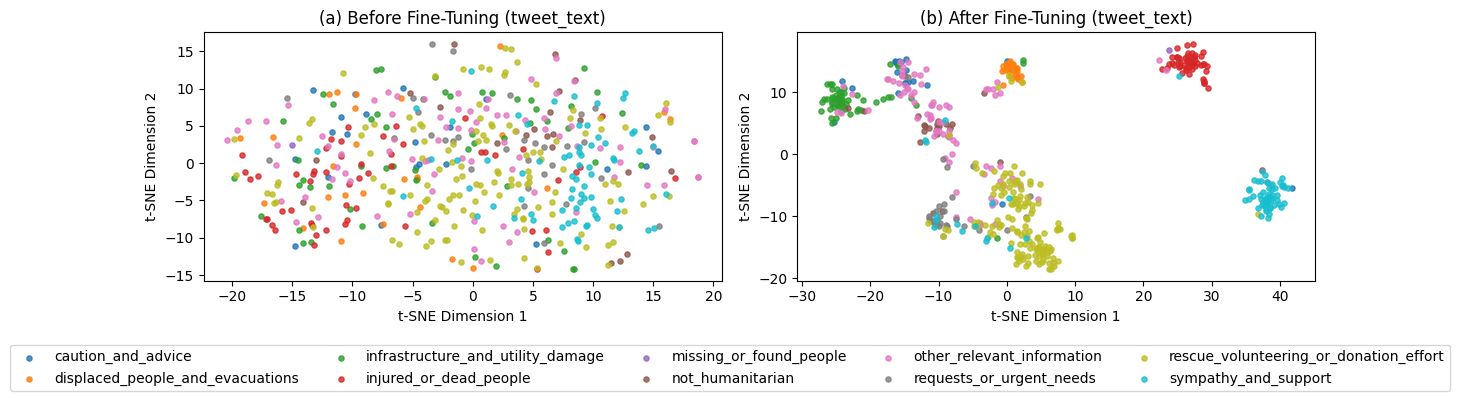

In [27]:
set_seed(SEED)

# 1) load dataset
dataset = load_local_tsv_dataset(TSV_PATH, DEV_SPLIT_VALUE)

# 2) labels
labels, label2id, id2label = build_label_mappings(dataset)
dataset = add_numeric_labels(dataset, label2id)

# 3) sample from test (recommended)
subset = sample_subset(dataset["test"], NUM_SAMPLES, seed=SEED)
texts = subset[TEXT_COLUMN]
labels_np = np.array(subset["label"])

# 4) tokenizer
tokenizer = AutoTokenizer.from_pretrained(BERT_NAME)

# 5) before FT encoder
bert_base = AutoModel.from_pretrained(BERT_NAME)

# 6) after FT encoder (load classifier, then use .bert)
finetuned_cls = AutoModelForSequenceClassification.from_pretrained(FINETUNED_MODEL_DIR)
bert_finetuned = finetuned_cls.bert

print("Computing embeddings (before fine-tuning)...")
emb_before = compute_cls_embeddings(bert_base, tokenizer, texts, device=DEVICE,
                                    batch_size=BATCH_SIZE, max_length=MAX_LENGTH)

print("Computing embeddings (after fine-tuning)...")
emb_after = compute_cls_embeddings(bert_finetuned, tokenizer, texts, device=DEVICE,
                                   batch_size=BATCH_SIZE, max_length=MAX_LENGTH)

print("Running t-SNE...")
tsne_before = run_tsne(emb_before, random_state=SEED)
tsne_after = run_tsne(emb_after, random_state=SEED)

plot_before_after(tsne_before, tsne_after, labels_np, id2label,
                  title_suffix=f" ({TEXT_COLUMN})", out_png=OUT_PNG)
